In [30]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalMaxPooling1D, MaxPooling1D, LSTM, Dense, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Load Data

In [33]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-10-26 02:40:28--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2020-10-26 02:40:28 (14.4 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [34]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [35]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Drop unknown columns

In [36]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Labeling column and target

In [37]:
df.columns = ['labels', 'data']

In [38]:
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df.head()

,labels,data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Data Preparation

Train / Test Split

In [39]:
X = df.data.values
y = df.labels.values

In [40]:
X.shape

(5572,)

In [41]:
y.shape

(5572,)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Text Preprocessing

In [43]:
# Tokenize data
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

In [44]:
# map int sequence -> vector
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Num of token: {V}')

Num of token: 7245


In [45]:
# pad sequence to get same length
X_train_pad = pad_sequences(X_train_tok)
print(f'X_train_pad shape: {X_train_pad.shape}')

X_train_pad shape: (3733, 121)


In [46]:
T = X_train_pad.shape[1]

In [47]:
X_test_pad = pad_sequences(X_test_tok, maxlen=T)
print(f'X_test_pad shape: {X_test_pad.shape}')

X_test_pad shape: (1839, 121)


## RNN

### Model Train

In [48]:
M = 15
D = 20

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

In [49]:
model = Model(i, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 121, 20)           144920    
_________________________________________________________________
lstm_1 (LSTM)                (None, 121, 15)           2160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 147,096
Trainable params: 147,096
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
r = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10)

Epoch 1/10
117/117 [==============================] - 5s 43ms/step - loss: 0.4856 - accuracy: 0.8307 - val_loss: 0.3907 - val_accuracy: 0.8662
Epoch 2/10
117/117 [==============================] - 5s 40ms/step - loss: 0.3612 - accuracy: 0.8658 - val_loss: 0.3236 - val_accuracy: 0.8662
Epoch 3/10
117/117 [==============================] - 5s 40ms/step - loss: 0.3061 - accuracy: 0.8658 - val_loss: 0.2879 - val_accuracy: 0.8662
Epoch 4/10
117/117 [==============================] - 5s 40ms/step - loss: 0.2647 - accuracy: 0.8658 - val_loss: 0.2438 - val_accuracy: 0.8662
Epoch 5/10
117/117 [==============================] - 5s 40ms/step - loss: 0.2076 - accuracy: 0.8711 - val_loss: 0.1777 - val_accuracy: 0.9483
Epoch 6/10
117/117 [==============================] - 5s 40ms/step - loss: 0.1087 - accuracy: 0.9890 - val_loss: 0.0854 - val_accuracy: 0.9875
Epoch 7/10
117/117 [==============================] - 5s 41ms/step - loss: 0.0513 - accuracy: 0.9962 - val_loss: 0.0609 - val_accuracy: 0.9897

### Model Evaluation

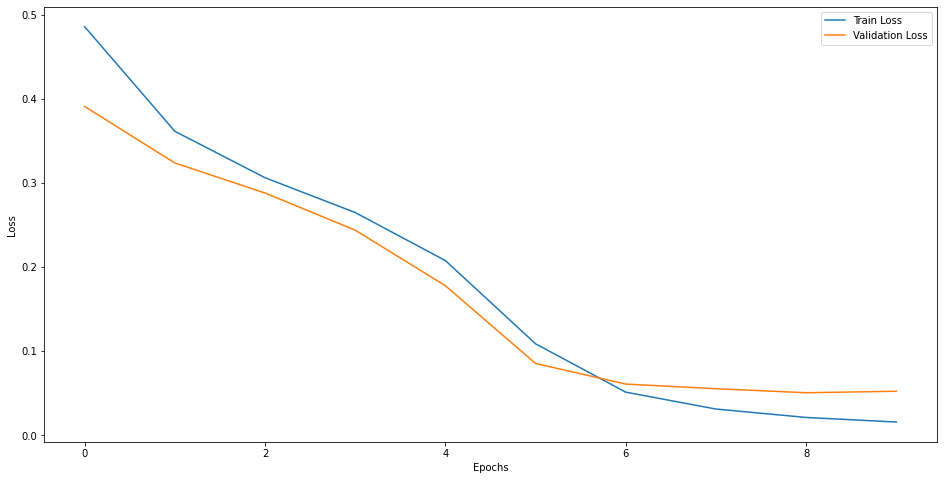

In [52]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

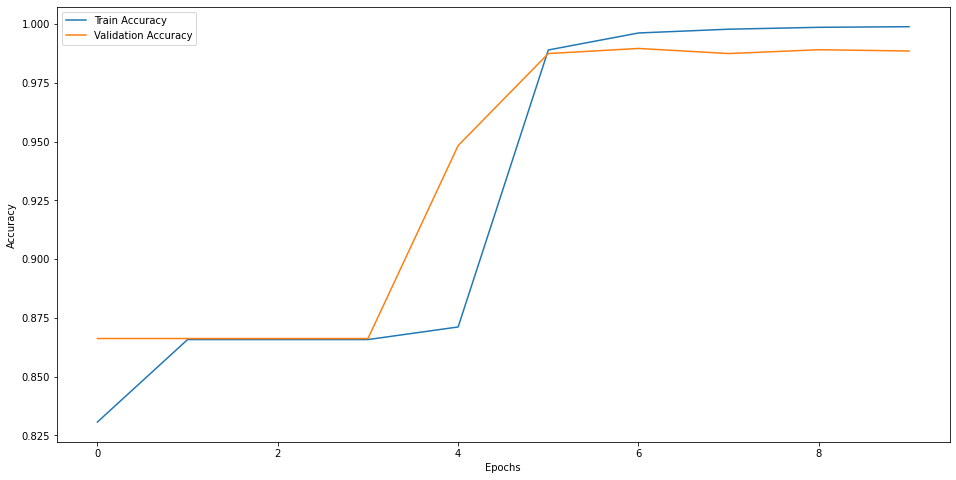

In [53]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN

### Model Train

In [54]:
D = 20

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

In [55]:
model = Model(i, x)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 121, 20)           144920    
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)          

In [56]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
r = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10)

Epoch 1/10
117/117 [==============================] - 2s 14ms/step - loss: 0.4059 - accuracy: 0.8642 - val_loss: 0.3570 - val_accuracy: 0.8662
Epoch 2/10
117/117 [==============================] - 1s 12ms/step - loss: 0.2020 - accuracy: 0.9188 - val_loss: 0.0909 - val_accuracy: 0.9750
Epoch 3/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.0859 - val_accuracy: 0.9788
Epoch 4/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0962 - val_accuracy: 0.9815
Epoch 5/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 0.0887 - val_accuracy: 0.9826
Epoch 6/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.1017 - val_accuracy: 0.9831
Epoch 7/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0958 - val_accuracy: 0.9842

### Model Evaluation

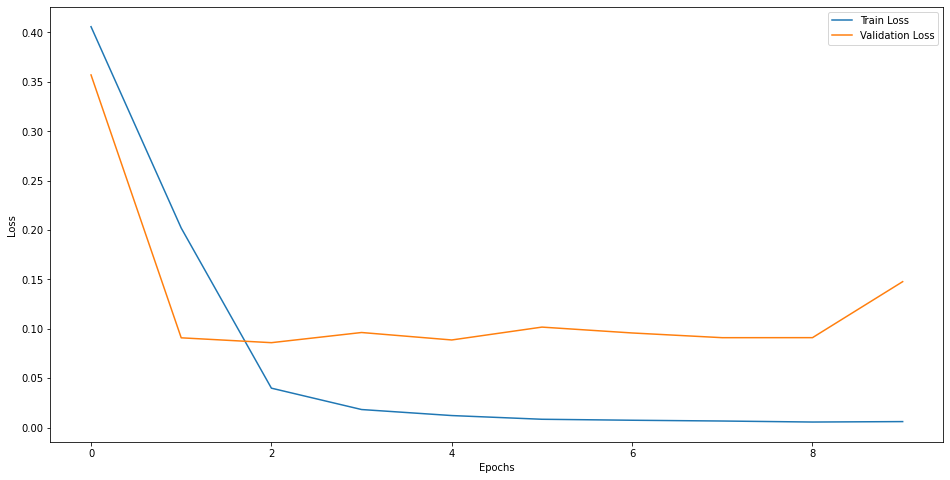

In [58]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

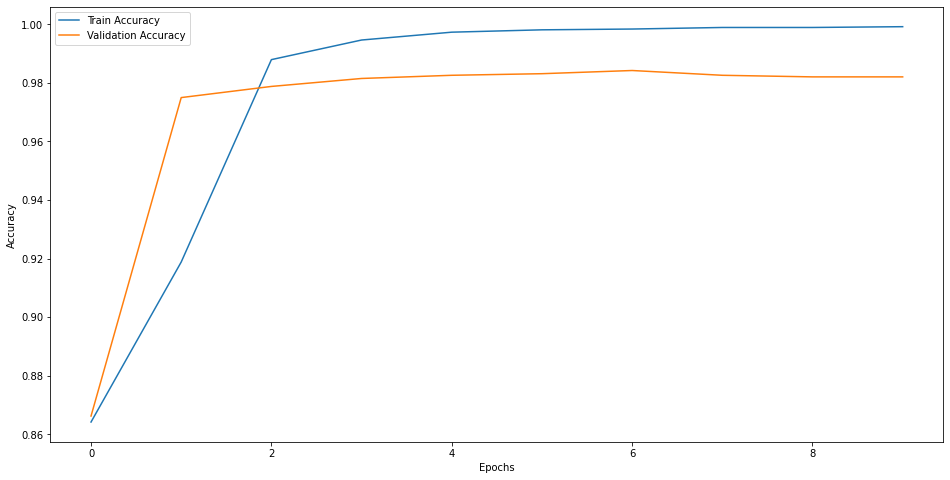

In [59]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()